In [2]:
using PyCall

py"""
import pickle, os
from urllib.request import urlopen 
import numpy as np

from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name))

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]
np.save("X_ordered.npy", X_ordered)
np.save("Y_ordered.npy", Y_ordered)
np.save("X_disordered.npy", X_disordered)
np.save("Y_disordered.npy", Y_disordered)
np.save("X_critical.npy", X_critical)
np.save("Y_critical.npy", Y_critical)

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)
"""

In [1]:
include("../src/classification.jl")
using Main.Classification

In [2]:
using NPZ: npzread
X_ordered = npzread("X_ordered.npy")
Y_ordered = npzread("Y_ordered.npy")
X_disordered = npzread("X_disordered.npy")
Y_disordered = npzread("Y_disordered.npy");


# define training and test data sets
X=[X_ordered; X_disordered]
Y=[Y_ordered; Y_disordered]

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=traintestsplit(X,Y, 0.8)

InterruptException: InterruptException:

In [11]:
using NPZ: npzread

N = 5000
X_train = convert(Matrix{Float64}, npzread("X_train.npy"))[1:N, :]
Y_train = convert(Vector{Float64}, npzread("Y_train.npy"))[1:N]
X_test = convert(Matrix{Float64}, npzread("X_test.npy"))[1:N, :]
Y_test = convert(Vector{Float64}, npzread("Y_test.npy"))[1:N];

In [12]:
nagd = NAGDContext(learningrate=0.001, tolerance=1e-5, maxiterations=100, batchsize=100)
clf_nagd = LogisticClassifier(NesterovGradientDescent(nagd))
add_designmatrix!(clf_nagd, copy(X_train))
addvalidationset!(clf_nagd, X_test, Y_test, false)
@time fit!(clf_nagd, copy(Y_train))

@show clf_nagd.optimizer.converged

 39.467594 seconds (1.05 k allocations: 15.351 MiB)
clf_nagd.optimizer.converged = false


false

In [7]:
import PyPlot; const plt = PyPlot
using PyCall

In [25]:
@show score(clf_nagd, X_train, Y_train)
@show score(clf_nagd, X_test, Y_test)

score(clf_nagd, X_train, Y_train) = 0.5188
score(clf_nagd, X_test, Y_test) = 0.6892


0.6892

In [13]:
gd = GDContext(learningrate=0.001, tolerance=1e-7, maxiterations=100)
clf_gd = LogisticClassifier(GradientDescent(gd))
add_designmatrix!(clf_gd, X_train)
addvalidationset!(clf_gd, X_test, Y_test, false)
@time fit!(clf_gd, Y_train)

@show clf_gd.optimizer.converged

  2.197524 seconds (918 allocations: 36.379 MiB, 7.57% gc time)
clf_gd.optimizer.converged = false


false

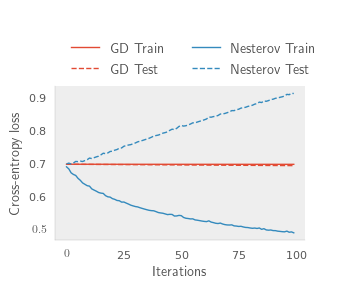

In [14]:
figpath = "../latex/figures"
@pywith plt.matplotlib.pyplot.style.context("rapport") begin
fig, ax = plt.subplots()
line = ax.plot(clf_gd.optimizer.validationloss, label="GD Train")
ax.plot(clf_gd.optimizer.loss, c=line[1].get_color(), ls="--", label="GD Test")
line= ax.plot(clf_nagd.optimizer.loss, label="Nesterov Train")
ax.plot(clf_nagd.optimizer.validationloss, c=line[1].get_color(), ls="--", label="Nesterov Test")
ax.set_ylabel("Cross-entropy loss")
fig.legend(loc=9, ncol=2, frameon=false,
            bbox_to_anchor=(0.1, 1.002, 1, 0.3))
 
ax.set_xlabel("Iterations")
#fig.savefig(figpath*"/GD_loss.png", dpi=300, transparent=true, bbox_inches="tight")
#ax.set_xscale("log")
end
#ax.set_yscale("log")

In [70]:

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

MethodError: MethodError: no method matching getindex(::Module, ::Symbol)

In [134]:
@show score(clf_gd, X_train, Y_train)
@show score(clf_gd, X_test, Y_test)
@show score(clf_nagd, X_train, Y_train)
@show score(clf_nagd, X_test, Y_test)

score(clf_gd, X_train, Y_train) = 0.6116
score(clf_gd, X_test, Y_test) = 0.4908
score(clf_nagd, X_train, Y_train) = 0.5184
score(clf_nagd, X_test, Y_test) = 0.7024


0.7024

In [133]:
using PyCall
sklearn = pyimport("sklearn")

logreg_SGD = sklearn.linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=100, 
                                        shuffle=true, random_state=1, learning_rate="optimal")
# fit training data
logreg_SGD.fit(X_train,Y_train)

PyObject SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=1, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [135]:
@show logreg_SGD.score(X_train,Y_train)
@show logreg_SGD.score(X_test,Y_test)

logreg_SGD.score(X_train, Y_train) = 0.7498
logreg_SGD.score(X_test, Y_test) = 0.5276


0.5276

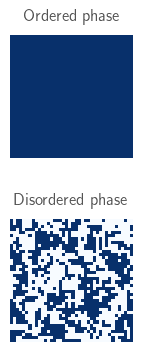

In [175]:
fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
@pywith plt.matplotlib.pyplot.style.context("rapport") begin
fig, ax = plt.subplots(nrows=2, figsize=(fig_width, 2*fig_height))
ax[1].matshow(reshape(X_train[11, :], 40, 40), cmap="Blues_r")
ax[1].axis("off")
ax[1].set_title("Ordered phase")
ax[2].matshow(reshape(X_train[1, :], 40, 40), cmap="Blues_r")
ax[2].axis("off")
ax[2].set_title("Disordered phase")
fig.savefig(figpath*"/matrix.png", dpi=300, transparent=true, bbox_inches="tight")
end

In [140]:
reshape(X_train[1, :], 40, 40)

40×40 Array{Float64,2}:
 -1.0   1.0  -1.0  -1.0   1.0   1.0  …   1.0   1.0   1.0  -1.0   1.0   1.0
 -1.0   1.0  -1.0  -1.0   1.0   1.0      1.0   1.0   1.0   1.0   1.0   1.0
 -1.0  -1.0  -1.0  -1.0   1.0   1.0     -1.0   1.0   1.0   1.0   1.0  -1.0
 -1.0  -1.0   1.0  -1.0   1.0  -1.0      1.0   1.0   1.0   1.0   1.0  -1.0
  1.0   1.0   1.0  -1.0  -1.0   1.0     -1.0  -1.0   1.0   1.0   1.0   1.0
 -1.0   1.0   1.0   1.0   1.0   1.0  …   1.0   1.0   1.0   1.0   1.0  -1.0
  1.0   1.0  -1.0   1.0   1.0   1.0      1.0   1.0   1.0   1.0   1.0   1.0
  1.0  -1.0  -1.0   1.0   1.0   1.0     -1.0  -1.0  -1.0   1.0   1.0   1.0
 -1.0   1.0  -1.0  -1.0   1.0   1.0      1.0  -1.0  -1.0  -1.0   1.0  -1.0
 -1.0   1.0  -1.0   1.0   1.0   1.0      1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0   1.0  …   1.0   1.0   1.0   1.0   1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0   1.0     -1.0   1.0  -1.0  -1.0   1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0   1.0     -1.0  -1.0  -1.0  -1.0   1.0   1.0
 